In [1]:
import pandas as pd
import numpy as np
import random


import matplotlib.pyplot as plt
import seaborn as sns



import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Sequential


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from collections import defaultdict


import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

In [2]:
# borrowed and modified from Denvir's code
def parse_spectrogram_and_metadata(melspec_path, split_path, metadata_path):
    # Load mel spectrograms
    melspec_dict = np.load(melspec_path, allow_pickle=True).item()

    # Load split and label info
    split_df = pd.read_csv(split_path)
    split_df['key'] = split_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    split_df = split_df.set_index('key')

    # Load downsampled metadata
    meta_df = pd.read_csv(metadata_path)
    meta_df['key'] = meta_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    meta_df = meta_df.set_index('key')

    X_img, X_meta, y, splits = [], [], [], []

    for key in meta_df.index:
        if key not in melspec_dict or key not in split_df.index:
            continue

        img = melspec_dict[key]
        info = split_df.loc[key]
        meta_row = meta_df.loc[key]

        metadata = np.array([
            float(meta_row['latitude']),
            float(meta_row['longitude']),
            float(meta_row['call']),
            float(meta_row['song/canto'])
        ], dtype=np.float32)

        X_img.append(img)
        X_meta.append(metadata)
        y.append(info['y_species_encoded'])
        splits.append(info['split'])

    return np.array(X_img), np.array(X_meta), np.array(y), np.array(splits)


In [3]:
def split_data(X_img, X_meta, y, splits):
    split_map = defaultdict(lambda: ([], [], []))

    for i, split in enumerate(splits):
        split_map[split][0].append(X_img[i])
        split_map[split][1].append(X_meta[i])
        split_map[split][2].append(y[i])

    def to_np(t): return tuple(map(np.array, t))
    return {k: to_np(v) for k, v in split_map.items()}

In [5]:
X_img, X_meta, y, splits = parse_spectrogram_and_metadata(
    melspec_path= "../data/32/birdclef2025_melspec_5sec_32_32.npy",
    split_path= "../data/work_df_w_split_info.csv",
    metadata_path="../data/downsampled_metadata.csv"
)

In [6]:
X_img.shape

(400, 32, 32)

In [7]:
def build_basic_flatnn(input_shape_img, num_classes):

    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    model = models.Sequential()

    model.add(layers.Input(shape=input_shape_img))
    # flatten
    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dense(64, activation = "relu"))

    # output layer
    model.add(layers.Dense(num_classes, activation = "softmax"))

    # compile model
    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    
    return model


In [23]:
def build_combined_model(input_shape_img, meta_shape, num_classes):
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    # inputs
    img_input = layers.Input(shape = input_shape_img)
    meta_input = layers.Input(shape = (meta_shape, ))

    # flatten image
    x_img = layers.Flatten()(img_input)

    # combine with metadata
    x = layers.Concatenate()([x_img, meta_input])
    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dense(64, activation = "relu")(x)
    output = layers.Dense(num_classes, activation = "softmax")(x)

    model = Model(inputs =[img_input, meta_input], outputs = output)

    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    

    return model


In [17]:
# modified from Denvir's code

data_splits = split_data(X_img, X_meta, y, splits)

X_train_img, X_train_meta, y_train = data_splits['train']
X_val_img, X_val_meta, y_val = data_splits['val']
X_test_img, X_test_meta, y_test = data_splits['test']

# Omit adding channel dimension to spectrograms
# X_train_img = X_train_img[..., np.newaxis]  # becomes (259, 32, 32, 1)
# X_val_img = X_val_img[..., np.newaxis]
# X_test_img = X_test_img[..., np.newaxis]

X_train_img = X_train_img.astype(np.float32)
X_val_img = X_val_img.astype(np.float32)
X_test_img = X_test_img.astype(np.float32)

X_train_meta = X_train_meta.astype(np.float32)
X_val_meta = X_val_meta.astype(np.float32)
X_test_meta = X_test_meta.astype(np.float32)

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print(X_train_img.shape)  # --> (N, 32, 32, 1)
print(X_train_meta.shape) # --> (N, 4)
print(y_train.shape)      # --> (N,)

(259, 32, 32)
(259, 4)
(259,)


In [14]:
model_basic = build_basic_flatnn(
    input_shape_img=X_train_img.shape[1:],
    num_classes=len(np.unique(y))
)

model_basic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,716 (545.77 KB)

 Trainable params: 139,716 (545.77 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_combined = build_combined_model(
    input_shape_img= X_train_img.shape[1:],
    meta_shape = X_meta.shape[1],
    num_classes = len(np.unique(y))
)

model_combined.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1028)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    131,712 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        260 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 140,228 (547.77 KB)

 Trainable params: 140,228 (547.77 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [25]:
num_classes = len(np.unique(y))

y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

In [26]:
scaler = StandardScaler()
X_train_meta = scaler.fit_transform(X_train_meta)
X_val_meta = scaler.transform(X_val_meta)
X_test_meta = scaler.transform(X_test_meta)

In [27]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [28]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# data augmentation
X_train_img_aug = augment_spectrogram(X_train_img)


In [29]:
history = model_basic.fit(
    x = X_train_img_aug,
    y = y_train_oh,
    validation_data = (X_val_img, y_val_oh),
    class_weight = class_weights,
    epochs = 50,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 4s 624ms/step - accuracy: 0.2812 - loss: 1.4652

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2876 - loss: 1.4415 - val_accuracy: 0.2877 - val_loss: 1.3943
Epoch 2/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2500 - loss: 1.3034

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2945 - loss: 1.3659 - val_accuracy: 0.3014 - val_loss: 1.3716
Epoch 3/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4062 - loss: 1.2616

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3406 - loss: 1.3186 - val_accuracy: 0.3014 - val_loss: 1.3561
Epoch 4/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4688 - loss: 1.2171

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3835 - loss: 1.2828 - val_accuracy: 0.3288 - val_loss: 1.3397
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3808 - loss: 1.2529 - val_accuracy: 0.3151 - val_loss: 1.3419
Epoch 6/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4688 - loss: 1.1680

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4524 - loss: 1.2054 - val_accuracy: 0.2877 - val_loss: 1.3333
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4335 - loss: 1.1940 - val_accuracy: 0.2740 - val_loss: 1.3341
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4573 - loss: 1.1750 - val_accuracy: 0.3151 - val_loss: 1.3409
Epoch 9/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4688 - loss: 1.0984

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5054 - loss: 1.1291 - val_accuracy: 0.3288 - val_loss: 1.3290
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5113 - loss: 1.1064 - val_accuracy: 0.3151 - val_loss: 1.3343
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5266 - loss: 1.0867 - val_accuracy: 0.3151 - val_loss: 1.3386
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5150 - loss: 1.0633 - val_accuracy: 0.3425 - val_loss: 1.3358
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5665 - loss: 1.0356 - val_accuracy: 0.3151 - val_loss: 1.3534
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5612 - loss: 1.0119 - val_accuracy: 0.3699 - val_loss: 1.3709
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5564 - loss: 0.9929 - val_accuracy: 0.3562 - val_loss: 1.3946
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5978 - loss: 0.9729 - val_accuracy: 0.3288 - val_loss: 1.4123
Epoch 17/

In [30]:
history_combined = model_combined.fit(
    x = [X_train_img_aug, X_train_meta],
    y = y_train_oh,
    validation_data = ([X_val_img, X_val_meta], y_val_oh),
    class_weight = class_weights,
    epochs = 50,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2844 - loss: 1.4353 - val_accuracy: 0.2466 - val_loss: 1.3970
Epoch 2/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4062 - loss: 1.2019

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3650 - loss: 1.3412 - val_accuracy: 0.3562 - val_loss: 1.3109
Epoch 3/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5000 - loss: 1.2109

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4526 - loss: 1.2277 - val_accuracy: 0.3699 - val_loss: 1.2729
Epoch 4/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5312 - loss: 1.0680

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5359 - loss: 1.1236 - val_accuracy: 0.4658 - val_loss: 1.2183
Epoch 5/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5625 - loss: 1.0210

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5362 - loss: 1.0767 - val_accuracy: 0.4247 - val_loss: 1.1873
Epoch 6/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5938 - loss: 0.9729

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5965 - loss: 1.0167 - val_accuracy: 0.4658 - val_loss: 1.1600
Epoch 7/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - loss: 0.8992

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5942 - loss: 0.9585 - val_accuracy: 0.5068 - val_loss: 1.1540
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6174 - loss: 0.9187 - val_accuracy: 0.4932 - val_loss: 1.1628
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6380 - loss: 0.8907 - val_accuracy: 0.4932 - val_loss: 1.1554
Epoch 10/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6250 - loss: 0.7873

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6574 - loss: 0.8577 - val_accuracy: 0.5616 - val_loss: 1.1472
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6934 - loss: 0.8268 - val_accuracy: 0.5205 - val_loss: 1.1653
Epoch 12/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7188 - loss: 0.7360

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7189 - loss: 0.8134 - val_accuracy: 0.5068 - val_loss: 1.1094
Epoch 13/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.7010

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7557 - loss: 0.7768 - val_accuracy: 0.5616 - val_loss: 1.0352
Epoch 14/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8125 - loss: 0.6508

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7868 - loss: 0.7318 - val_accuracy: 0.5342 - val_loss: 1.0343
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7825 - loss: 0.7117 - val_accuracy: 0.5068 - val_loss: 1.0651
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7777 - loss: 0.7099 - val_accuracy: 0.5205 - val_loss: 1.1195
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7305 - loss: 0.7152 - val_accuracy: 0.5068 - val_loss: 1.1192
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7557 - loss: 0.6912 - val_accuracy: 0.5205 - val_loss: 1.0943
Epoch 19/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.6327

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7555 - loss: 0.6633 - val_accuracy: 0.5479 - val_loss: 1.0201
Epoch 20/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7812 - loss: 0.5715

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7660 - loss: 0.6226 - val_accuracy: 0.5753 - val_loss: 1.0011
Epoch 21/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8750 - loss: 0.5457

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8107 - loss: 0.5868 - val_accuracy: 0.5890 - val_loss: 1.0008
Epoch 22/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8443 - loss: 0.5520 - val_accuracy: 0.5616 - val_loss: 1.0242
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8558 - loss: 0.5166 - val_accuracy: 0.5890 - val_loss: 1.0632
Epoch 24/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8484 - loss: 0.4949 - val_accuracy: 0.6164 - val_loss: 1.0889
Epoch 25/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8504 - loss: 0.4738 - val_accuracy: 0.5753 - val_loss: 1.0964
Epoch 26/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8670 - loss: 0.4542 - val_accuracy: 0.5890 - val_loss: 1.1206
Epoch 27/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8670 - loss: 0.4377 - val_accuracy: 0.5890 - val_loss: 1.1563
Epoch 28/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8686 - loss: 0.4225 - val_accuracy: 0.5890 - val_loss: 1.1631
Epoch 29

In [31]:
# Evaluate the model on the test set
test_loss, test_acc = model_basic.evaluate(
    X_test_img,
    y_test_oh
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3132 - loss: 1.3512
Test Accuracy: 0.3529
Test Loss: 1.3176


In [39]:
test_loss, test_acc = model_combined.evaluate(
    [X_test_img, X_test_meta],
    y_test_oh
)


val_loss, val_acc = model_combined.evaluate(
    [X_val_img, X_val_meta],
    y_val_oh
)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

print(f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5827 - loss: 0.9490 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5875 - loss: 0.9950
Test Accuracy: 0.6029
Test Loss: 0.9107
val loss: 1.0008, val acc: 0.5890


In [33]:
# Get predicted class indices
y_pred_basic_first = model_basic.predict(X_test_img)
y_pred_basic = y_pred_basic_first.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred_basic))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
              precision    recall  f1-score   support

           0       0.21      0.31      0.25        13
           1       0.00      0.00      0.00        16
           2       0.48      0.53      0.50        19
           3       0.43      0.50      0.47        20

    accuracy                           0.35        68
   macro avg       0.28      0.33      0.30        68
weighted avg       0.30      0.35      0.32        68



In [40]:
# Get predicted class indices
y_pred_c = model_combined.predict([X_test_img, X_test_meta])
y_pred_combined = y_pred_c.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred_combined))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

           0       0.31      0.38      0.34        13
           1       0.62      0.62      0.62        16
           2       0.69      0.58      0.63        19
           3       0.75      0.75      0.75        20

    accuracy                           0.60        68
   macro avg       0.59      0.58      0.59        68
weighted avg       0.62      0.60      0.61        68



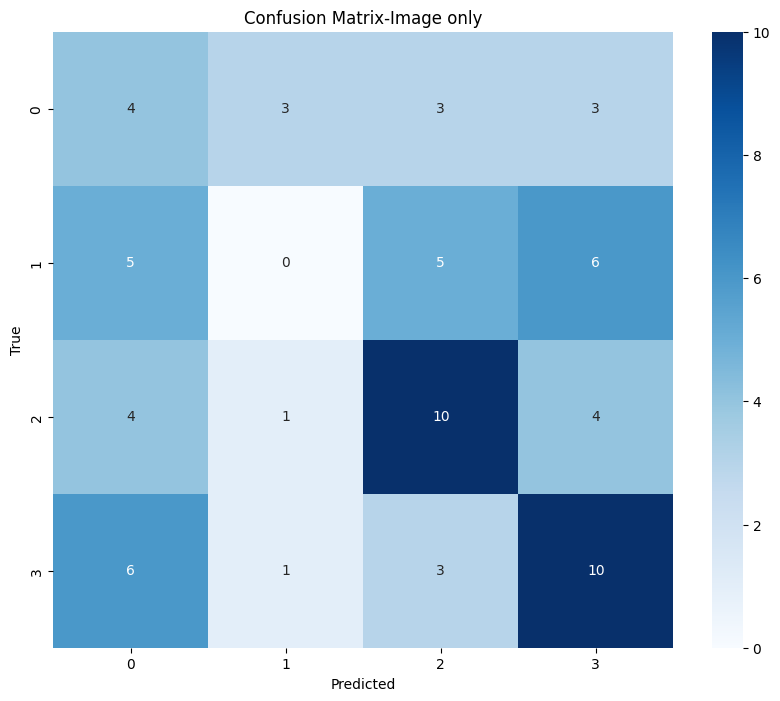

In [35]:
cm = confusion_matrix(y_test, y_pred_basic)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix-Image only')
plt.show()

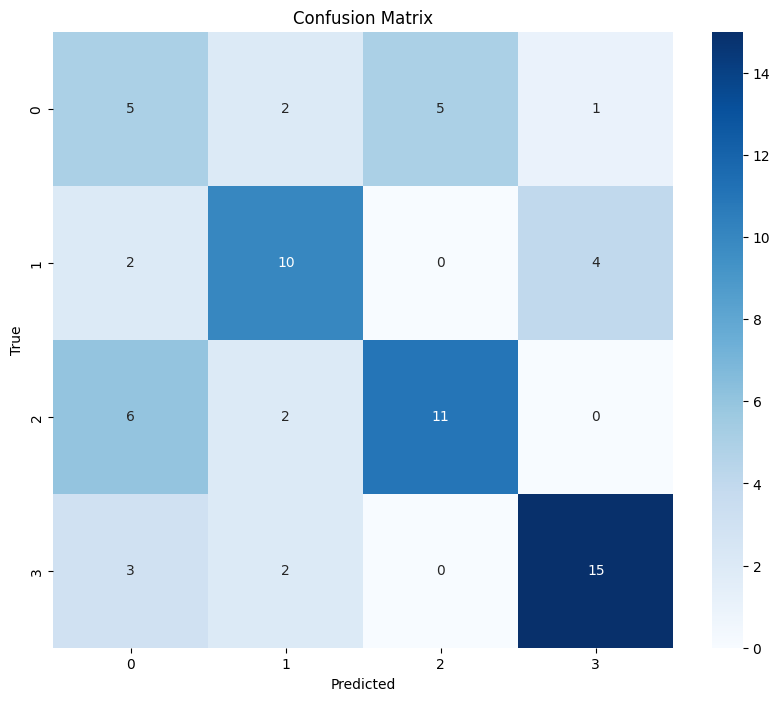

In [38]:
cm = confusion_matrix(y_test, y_pred_combined)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()